In [39]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
from itertools import combinations
import tabulate
import matplotlib.colors 

import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import cartopy.crs as ccrs
import cartopy as ctp
import cartopy.feature as cfeature

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg


from climada.entity import Exposures
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone

from climada.engine import ImpactCalc

from climada.hazard import TCTracks, Centroids, TropCyclone
from climada.hazard import Hazard

from climada.util.api_client import Client
import climada.util.yearsets as yearsets


*Note: If you change the Cmpany file you don't need to re-run the hazard inititation every time. Just 'Run all', without restarting the Kernell* 

# Parameters


In [40]:
# The company data file name
cpnys_file_name = 'Company examples & locations.xlsx'

# The company reference column
company_ref = 'Company Name'

# Exclude companies based on column values
exclude_companies =  {'Company Name': ['FRED']}

# Make all the companies have the same asset value
all_same_asset_value = None # 1

# Give the coverage limit and deductible for all companies
# coverage_limit should in prct of the asset value in range [50, 100] %%!
# deductible should be in prct of the asset value in range [0, 10] %%!
coverage_limit_dict =  {'Globe Pharma': 50, 'NWP SEMICON': 30}
deductible_dict =  {'Globe Pharma': 5, 'NWP SEMICON': 1}

# The return period
return_period = 100

# The alpha value for the VaR and ES calculation ( Move to back)
alpha = 1/return_period

# The number of years to simulate
n_years = 10000

# Merged and rescale all avaible future hazard models
use_all_future_sets = False # False



# Initiate Hazard object

## Store Hazard sets in dictionary

In [41]:
if 'haz_dict' not in globals(): # Check if the hazard set has been loaded
    # Define time period
    time_periods = ['Historical', 'Current', 'Future']

    # Initialise the client
    client = Client()

    # Get the hazard set info
    hazard_type = 'tropical_cyclone'
    info_tc = client.list_dataset_infos('tropical_cyclone')
    print(client.get_property_values(info_tc))

    # Store the currrent hazard sets in a dictionary
    haz_dict = {time_period: None for time_period in time_periods}

    ## Get the current hazard set
    properties_curr = {'model_name': 'STORM', 'spatial_coverage': 'global', 'name':'TC_global_0300as_STORM'}
    haz_dict[time_periods[1]] = client.get_hazard(hazard_type, properties=properties_curr)

    ## Select future hazard set
    # Available future hazard sets
    available_fut_haz_sets = ['TC_global_0300as_STORM_CNRM-CM6-1-HR', 'TC_global_0300as_STORM_EC-Earth3P-HR'] # Available future hazard sets from the API 
    if not use_all_future_sets:
        # Select the first future hazard set
        haz_dict[time_periods[2]] = client.get_hazard(hazard_type, properties={'model_name': 'STORM', 'spatial_coverage': 'global', 'name': available_fut_haz_sets[0]})
    else:
        # Store in list
        haz_fut_list = []
        for fut_haz_set in available_fut_haz_sets:
            haz_fut_list.append(client.get_hazard(hazard_type, properties={'model_name': 'STORM', 'spatial_coverage': 'global', 'name': fut_haz_set}))
        # Merge and rescale the future hazard sets
        haz_future = Hazard.concat(haz_fut_list)
        # Rescale the future hazard set frequency
        haz_future.frequency = haz_future.frequency / len(haz_fut_list)
        # Store the future hazard set
        haz_dict[time_periods[2]] = haz_future
            

    ## Get the historical hazard set
    properties_curr = { 'spatial_coverage': 'global', 'event_type': 'observed' }
    haz_dict[time_periods[0]] = client.get_hazard(hazard_type, properties=properties_curr)

# Plot the hazard set
#haz_dict['Historical'].plot_intensity(0)
#haz_dict['Current'].plot_intensity(0) # Plot current hazard set
#haz_dict['Future'].plot_intensity(0) # Plot future hazard set

### Poster plot - Hazard Intensities

In [42]:
# Assume haz is your object and plot_intensity is the method you want to use
#axis = haz_dict['Historical'].plot_intensity(0)  # Call the method as you normally would
#axis.set_title("")  # Sets an empty title, effectively removing it
#axis.axis('off')
#plt.show()

# Impact functions

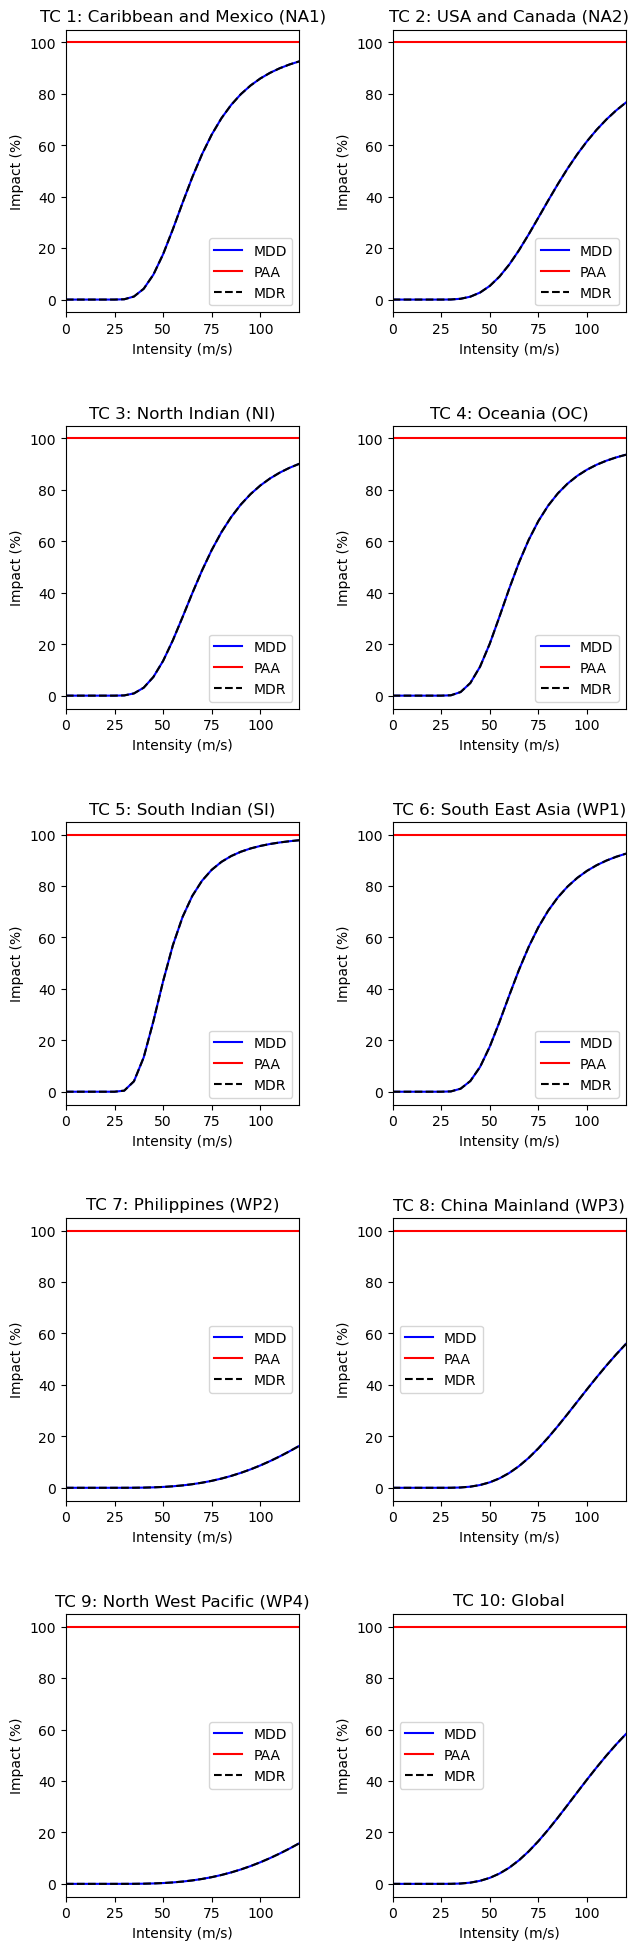

In [43]:
# generate the default calibrated TC impact functions for different regions
imp_fun_set_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

# plot all the impact functions
imp_fun_set_TC.plot()
# adjust the plots
plt.subplots_adjust(right=1., top=4., hspace=0.4, wspace=0.4)

# Exposure object


In [44]:
# Read the Excel file into a pandas DataFrame
exp_df = pd.read_excel(cpnys_file_name, usecols="A:K", sheet_name = 'Property values')  #Read only columns A to H  
# Remove the rows with no location
exp_df = exp_df[exp_df['Latitude'].notna()]
# Rename the columns using a dictionary
exp_df = exp_df.rename(columns={"Latitude": "latitude", "Longitude": "longitude", "Value (US$ billion)": "value"})

# See if the values should be equal to same value
if all_same_asset_value == 1:
    exp_df['value'] = all_same_asset_value

# Exclude companies
if exclude_companies is not None:
    for key in exclude_companies:
        for value in exclude_companies[key]:
            exp_df = exp_df[exp_df[key] != value]

In [45]:
# Map the impact function to the exposures assets 

## countries by region:
region_ids_cal = {'NA1': ['AIA', 'ATG', 'ARG', 'ABW', 'BHS', 'BRB', 'BLZ', 
                          'BMU', 'BOL', 'CPV', 'CYM', 'CHL', 'COL', 'CRI', 
                          'CUB', 'DMA', 'DOM', 'ECU', 'SLV', 'FLK', 'GUF', 
                          'GRD', 'GLP', 'GTM', 'GUY', 'HTI', 'HND', 'JAM', 
                          'MTQ', 'MEX', 'MSR', 'NIC', 'PAN', 'PRY', 'PER', 
                          'PRI', 'SHN', 'KNA', 'LCA', 'VCT', 'SXM', 'SUR', 
                          'TTO', 'TCA', 'URY', 'VEN', 'VGB', 'VIR'], \
                  'NA2': ['CAN', 'USA'], \
                  'NI': ['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'DJI', 
                         'ERI', 'ETH', 'GEO', 'IND', 'IRN', 'IRQ', 'ISR', 
                         'JOR', 'KAZ', 'KWT', 'KGZ', 'LBN', 'MDV', 'MNG', 
                         'MMR', 'NPL', 'OMN', 'PAK', 'QAT', 'SAU', 'SOM', 
                         'LKA', 'SYR', 'TJK', 'TKM', 'UGA', 'ARE', 'UZB', 
                         'YEM'], \
                  'OC': ['ASM', 'AUS', 'COK', 'FJI', 'PYF', 'GUM', 'KIR', 
                         'MHL', 'FSM', 'NRU', 'NCL', 'NZL', 'NIU', 'NFK', 
                         'MNP', 'PLW', 'PNG', 'PCN', 'WSM', 'SLB', 'TLS', 
                         'TKL', 'TON', 'TUV', 'VUT', 'WLF'], \
                  'SI': ['COM', 'COD', 'SWZ', 'MDG', 'MWI', 'MLI', 'MUS', 
                         'MOZ', 'ZAF', 'TZA', 'ZWE'], \
                  'WP1': ['KHM', 'IDN', 'LAO', 'MYS', 'THA', 'VNM'], \
                  'WP2': ['PHL'], \
                  'WP3': ['CHN'], \
                  'WP4': ['HKG', 'JPN', 'KOR', 'MAC', 'TWN'], 
                  'ROW': ['ALB', 'DZA', 'AND', 'AGO', 'ATA', 'AUT', 'BLR', 
                          'BEL', 'BEN', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 
                          'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CMR', 'CAF', 
                          'TCD', 'CXR', 'CCK', 'COG', 'HRV', 'CUW', 'CYP', 
                          'CZE', 'CIV', 'DNK', 'EGY', 'GNQ', 'EST', 'FRO', 
                          'FIN', 'FRA', 'ATF', 'GAB', 'GMB', 'DEU', 'GHA', 
                          'GIB', 'GRC', 'GRL', 'GGY', 'GIN', 'GNB', 'HMD', 
                          'VAT', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY', 
                          'KEN', 'PRK', 'XKX', 'LVA', 'LSO', 'LBR', 'LBY', 
                          'LIE', 'LTU', 'LUX', 'MLT', 'MRT', 'MYT', 'MDA', 
                          'MCO', 'MNE', 'MAR', 'NAM', 'NLD', 'NER', 'NGA', 
                          'MKD', 'NOR', 'PSE', 'POL', 'PRT', 'ROU', 'RUS', 
                          'RWA', 'REU', 'BLM', 'MAF', 'SPM', 'SMR', 'STP', 
                          'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SVK', 'SVN', 
                          'SGS', 'SSD', 'ESP', 'SDN', 'SJM', 'SWE', 'CHE', 
                          'TGO', 'TUN', 'TUR', 'UKR', 'GBR', 'UMI', 'ESH', 
                          'ZMB', 'ALA']}

code_regions = {'NA1': 1, 'NA2': 2, 'NI': 3, 'OC': 4, 'SI': 5, 'WP1': 6, \
                    'WP2': 7, 'WP3': 8, 'WP4': 9, 'ROW': 10}

# Make data frame of countries and region ids and impf_TC id
contry_basin_coderegion = {'ISO3':[], 'region_id_cal': [], 'impf_TC': []}

for key, value in region_ids_cal.items():
    contry_basin_coderegion['ISO3'] += value
    contry_basin_coderegion['region_id_cal'] += [key]*len(value)
    contry_basin_coderegion['impf_TC'] += [code_regions[key]]*len(value)

contry_basin_coderegion_df = pd.DataFrame(contry_basin_coderegion)

# Merge the data frames
exp_df = pd.merge(exp_df, contry_basin_coderegion_df, on='ISO3', how='left')

In [46]:
# Define company identifier string

# Get the unique companies
companies = exp_df[company_ref].unique()

# Create an exposures object
exp_all = Exposures(exp_df)
# Check that the exposure data is valid
exp_all.check()

# Store the current and future exposures in a dictionary with each company as a key
exp_dict = {cpny: Exposures(exp_df[exp_df[company_ref].isin([cpny])]) for cpny in companies }

### Set insurance coverage

In [47]:
# Add the insurance data to the exposures
for cpny in companies:
    exp_dict[cpny].gdf['deductible'] = exp_dict[cpny].gdf.value * deductible_dict[cpny] / 100
    exp_dict[cpny].gdf['cover'] = exp_dict[cpny].gdf.value * coverage_limit_dict[cpny] / 100


In [48]:
exp_dict['Globe Pharma'].gdf

,Company Name,Industry,Company ID,Location ID,Country,ISO3,Location,Distribution,latitude,longitude,value,region_id_cal,impf_TC,deductible,cover
0,Globe Pharma,Pharmaceutical manufacturing,1.0,11.0,United States,USA,South Carolina,Global,33.8522,-83.3918,0.45,NA2,2,0.0225,0.225
1,Globe Pharma,Pharmaceutical manufacturing,1.0,12.0,United States,USA,South Carolina,Global,33.6925,-80.2388,1.80,NA2,2,0.0900,0.900
2,Globe Pharma,Pharmaceutical manufacturing,1.0,13.0,United States,USA,Florida,Global,29.8131,-82.2863,0.65,NA2,2,0.0325,0.325
3,Globe Pharma,Pharmaceutical manufacturing,1.0,14.0,Mexico,MEX,Puebla,Global,18.8815,-98.3820,0.90,NA1,1,0.0450,0.450
4,Globe Pharma,Pharmaceutical manufacturing,1.0,15.0,Brazil,BRA,Rio de Janeiro,Global,-22.3102,-42.5884,0.75,ROW,10,0.0375,0.375
5,Globe Pharma,Pharmaceutical manufacturing,1.0,16.0,Ireland,IRL,Meath,Global,53.5133,-6.3871,0.30,ROW,10,0.0150,0.150
6,Globe Pharma,Pharmaceutical manufacturing,1.0,17.0,Germany,DEU,Hessen,Global,50.2071,8.6080,1.65,ROW,10,0.0825,0.825
7,Globe Pharma,Pharmaceutical manufacturing,1.0,18.0,China,CHN,Zhejiang,Global,28.5817,121.4557,1.30,WP3,8,0.0650,0.650
8,Globe Pharma,Pharmaceutical manufacturing,1.0,19.0,Japan,JPN,Aichi,Global,35.0914,137.1833,1.50,WP4,9,0.0750,0.750
9,Globe Pharma,Pharmaceutical manufacturing,1.0,20.0,Australia,AUS,New South Wales,Global,-32.8341,151.6556,0.70,OC,4,0.0350,0.350


### Total property value

In [49]:
# Compute the total asset value for each company
asset_tot_value_dict = {cpny: exp_dict[cpny].gdf.value.sum() for cpny in companies}

### Plot the Exposure data

/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning:

The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.

/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning:

The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.

/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning:

The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.



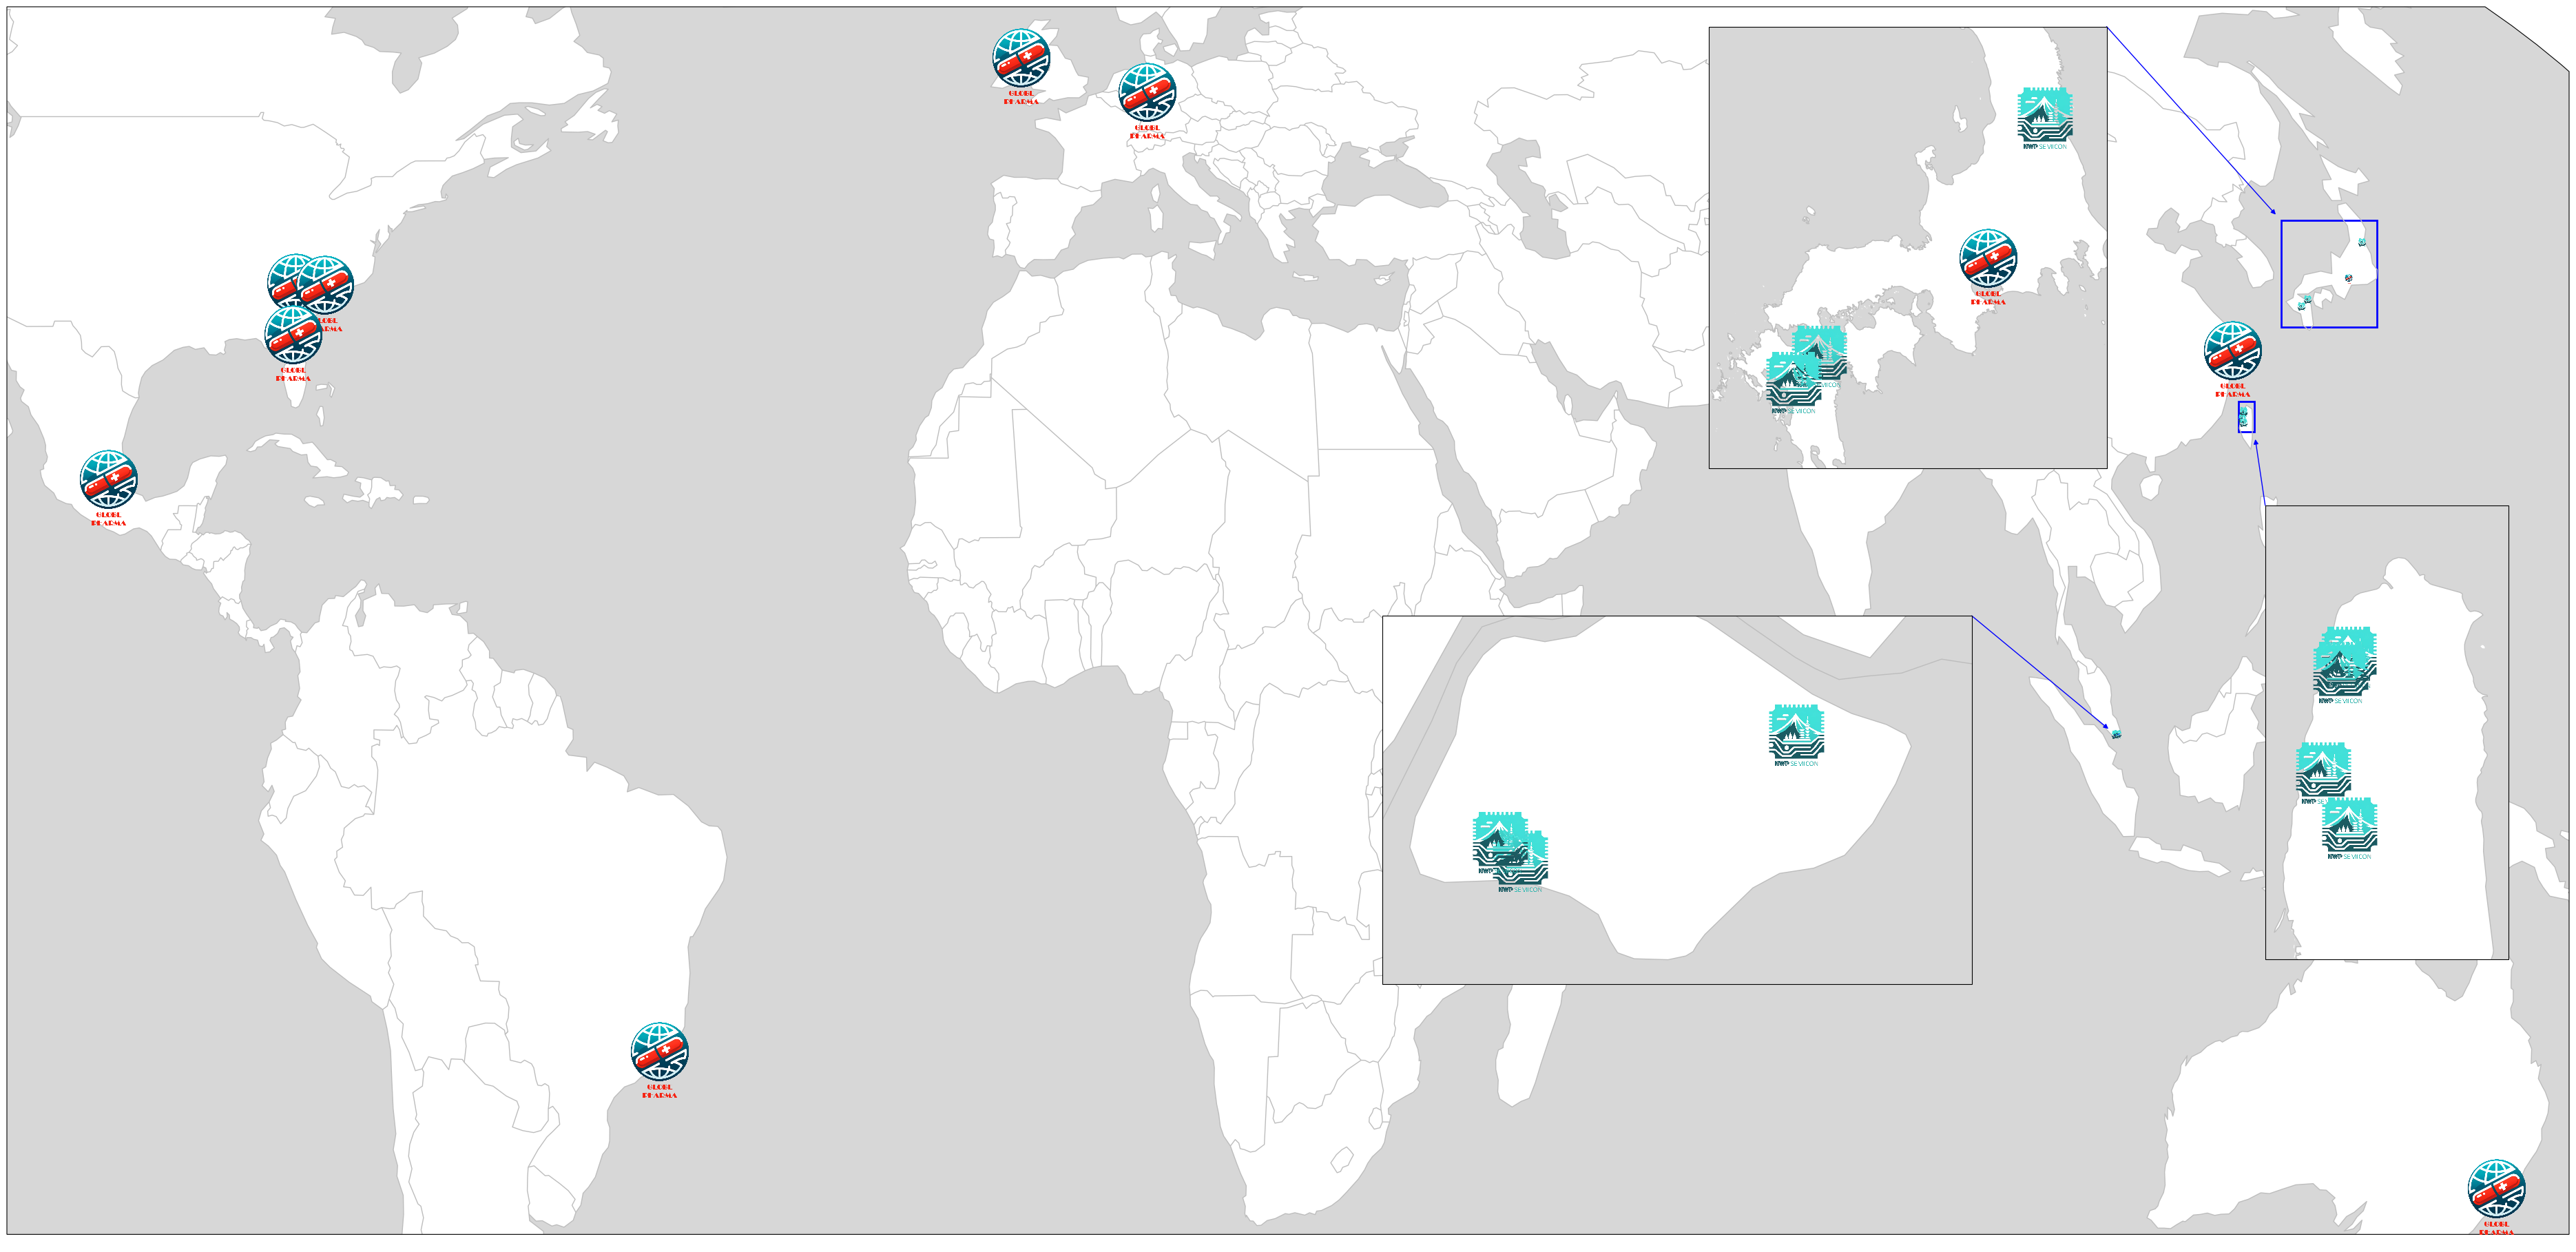

In [50]:
# Plot the exposures
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#57d3db', '#db5f57'])
label = ('NWP Semicon','Globe Pharma')
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Colours and labels for legend
color_map = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#57d3db', '#db5f57'])
label = ('NWP Semicon','Globe Pharma')

## Coordinates
x = exp_df['longitude']
y = exp_df['latitude']
z = exp_df['Company ID']

# Load your PNG images
Logo_Semi = 'Logos/Logo_NWP_Semicon.png'  # Update this path
Logo_Pharma = 'Logos/Logo_Globe_Pharma.png'  # Update this path
img_Semi = mpimg.imread(Logo_Semi)
img_Pharma = mpimg.imread(Logo_Pharma)

zoom_main = 0.08
zoom_inset = zoom_main
zoom_inset_rect = 0.01

# Function to add an image at a given (x, y) location
def plot_image_at_location(x, y, image, ax, zoom=0.015):
    # Transform data coordinates to map's projection
    x_proj, y_proj = ax.projection.transform_point(x, y, src_crs=ccrs.PlateCarree())
    
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x_proj, y_proj), xycoords='data', frameon=False)
    ax.add_artist(ab)


# Coordinates in meters in the Eckert IV projection to be transformed
x_min_world, x_max_world, y_min_world, y_max_world = 9.74e6, 9.78e6, 0.165e6, 0.19e6
x_min_jpn, x_max_jpn, y_min_jpn, y_max_jpn = 11.3e6, 12.2e6, 4.0e6, 5.0e6
x_min_twn, x_max_twn, y_min_twn, y_max_twn = 10.9e6, 11.05e6, 3.02e6, 3.3e6
x_min_sing, x_max_sing, y_min_sing, y_max_sing = 9.74e6, 9.78e6, 0.165e6, 0.19e6



## Make a worldmap
fig = plt.figure(figsize=(24*2, 16*2))
# Main map
# Create the main map in the left part of the grid
ax_main = fig.add_subplot(1,1,1, projection=ccrs.EckertIV())
ax_main.add_feature(cfeature.COASTLINE, edgecolor='#BDBDBD')
ax_main.add_feature(cfeature.BORDERS, edgecolor='#BDBDBD')
ax_main.add_feature(ctp.feature.OCEAN,facecolor='#D7D7D7')
ax_main.set_global()

# Set the extent of the map
ax_main.set_xlim([-10.0e6, 14e6])
ax_main.set_ylim([-4.5e6, 7e6])


# Loop through coordinates and plot the corresponding image
for xi, yi, zi in zip(x, y, z):
    img = img_Pharma if zi == 1.0 else img_Semi

    x_proj, y_proj = ax_main.projection.transform_point(xi, yi, src_crs=ccrs.PlateCarree())

    # Check if the coordinates are in the Japan, Taiwan, or Singapore region
    if (x_min_jpn <= x_proj <= x_max_jpn and y_min_jpn <= y_proj <= y_max_jpn) or \
       (x_min_twn <= x_proj <= x_max_twn and y_min_twn <= y_proj <= y_max_twn) or \
       (x_min_sing <= x_proj <= x_max_sing and y_min_sing <= y_proj <= y_max_sing):
        zoom = zoom_inset_rect  # Use a smaller zoom for these regions
    else:
        zoom = zoom_main  # Use the main zoom for other regions

    plot_image_at_location(xi, yi, img, ax_main, zoom)


# Create an inset Axes with a different projection (PlateCarree here)
# Coordinates in meters in the Eckert IV projection to be transformed
x_min, x_max, y_min, y_max = 10.5e6, 12.5e6, 2.5e6, 5.5e6

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Make sure cartopy's feature interface is correctly referenced
cfeature = cartopy.feature


# Create an inset Axes based on x_min, x_max, y_min, y_max
ax_inset_jpn = inset_axes(ax_main, width="40%", height="40%", loc='lower left',
                    bbox_to_anchor=(0.58, 0.62, 0.8, 0.9),
                    bbox_transform=ax_main.transAxes,
                    axes_class=cartopy.mpl.geoaxes.GeoAxes,
                    axes_kwargs=dict(map_projection=ccrs.EckertIV()))

# Remove ticks and labels from the inset axes
ax_inset_jpn.set_xticks([])
ax_inset_jpn.set_yticks([])
ax_inset_jpn.set_xticklabels([])
ax_inset_jpn.set_yticklabels([])

ax_inset_jpn.add_feature(cfeature.COASTLINE, edgecolor='#BDBDBD')
ax_inset_jpn.add_feature(cfeature.BORDERS, edgecolor='#BDBDBD')
ax_inset_jpn.add_feature(ctp.feature.OCEAN,facecolor='#D7D7D7')
ax_inset_jpn.set_global()

# Coordinates in meters in the Eckert IV projection to be transformed
x_min, x_max, y_min, y_max = x_min_jpn, x_max_jpn, y_min_jpn, y_max_jpn

# Set the extent of the map
ax_inset_jpn.set_xlim([x_min, x_max])
ax_inset_jpn.set_ylim([y_min, y_max])


# Loop through coordinates and plot the corresponding image
for xi, yi, zi in zip(x, y, z):

    x_proj, y_proj = ax_inset_jpn.projection.transform_point(xi, yi, src_crs=ccrs.PlateCarree())

    # Plot if the coordinates are within the extent
    if x_proj < x_min or x_proj > x_max or y_proj < y_min or y_proj > y_max:
        continue
    else:
        img = img_Pharma if zi == 1.0 else img_Semi
        plot_image_at_location(xi, yi, img, ax_inset_jpn, zoom=zoom_inset)


# Draw a rectangle on the main map to indicate the area shown in the inset
# Transform the Eckert IV projection coordinates to the figure's coordinate system
transform = ccrs.EckertIV()._as_mpl_transform(ax_main)
rectangle = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                            edgecolor='blue', facecolor='none',
                            transform=transform, linewidth=2)
ax_main.add_patch(rectangle)

from matplotlib.patches import ConnectionPatch

# After defining each inset, draw a line from the rectangle to the inset
xyA = (1, 1)  # coordinates to start the line in the inset (bottom left corner)
xyB = (x_min, y_max)  # coordinates to end the line in the main plot
coordsA = "axes fraction"
coordsB = "data"
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax_inset_jpn, axesB=ax_main,
                      arrowstyle="-|>", shrinkB=8, color="blue")
ax_inset_jpn.add_artist(con)





# Create an inset Axes based on x_min, x_max, y_min, y_max
ax_inset_twn = inset_axes(ax_main, width="50%", height="50%", loc='lower left',
                    bbox_to_anchor=(0.742, 0.22, 0.74, 0.74),
                    bbox_transform=ax_main.transAxes,
                    axes_class=cartopy.mpl.geoaxes.GeoAxes,
                    axes_kwargs=dict(map_projection=ccrs.EckertIV()))

# Remove ticks and labels from the inset axes
ax_inset_twn.set_xticks([])
ax_inset_twn.set_yticks([])
ax_inset_twn.set_xticklabels([])
ax_inset_twn.set_yticklabels([])

ax_inset_twn.add_feature(cfeature.COASTLINE, edgecolor='#BDBDBD')
ax_inset_twn.add_feature(cfeature.BORDERS, edgecolor='#BDBDBD')
ax_inset_twn.add_feature(ctp.feature.OCEAN,facecolor='#D7D7D7')
ax_inset_twn.set_global()

# Coordinates in meters in the Eckert IV projection to be transformed
x_min, x_max, y_min, y_max = x_min_twn, x_max_twn, y_min_twn, y_max_twn 

# Set the extent of the map
ax_inset_twn.set_xlim([x_min, x_max])
ax_inset_twn.set_ylim([y_min, y_max])

# Loop through coordinates and plot the corresponding image
for xi, yi, zi in zip(x, y, z):

    x_proj, y_proj = ax_inset_jpn.projection.transform_point(xi, yi, src_crs=ccrs.PlateCarree())

    # Plot if the coordinates are within the extent
    if x_proj < x_min or x_proj > x_max or y_proj < y_min or y_proj > y_max:
        continue
    else:
        img = img_Pharma if zi == 1.0 else img_Semi
        plot_image_at_location(xi, yi, img, ax_inset_twn, zoom=zoom_inset)




# Draw a rectangle on the main map to indicate the area shown in the inset
# Transform the Eckert IV projection coordinates to the figure's coordinate system
transform = ccrs.EckertIV()._as_mpl_transform(ax_main)
rectangle = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                            edgecolor='blue', facecolor='none',
                            transform=transform, linewidth=2)
ax_main.add_patch(rectangle)

# After defining each inset, draw a line from the rectangle to the inset
xyA = (0, 1)  # coordinates to start the line in the inset (bottom left corner)
xyB = (x_max, y_min)  # coordinates to end the line in the main plot
coordsA = "axes fraction"
coordsB = "data"
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax_inset_twn, axesB=ax_main,
                      arrowstyle="-|>", shrinkB=8, color="blue")
ax_inset_twn.add_artist(con)









##### Singapore 

# Create an inset Axes based on x_min, x_max, y_min, y_max
ax_inset_mal = inset_axes(ax_main, width="50%", height="50%", loc='lower left',
                    bbox_to_anchor=(0.5, 0.2, 0.6, 0.6),
                    bbox_transform=ax_main.transAxes,
                    axes_class=cartopy.mpl.geoaxes.GeoAxes,
                    axes_kwargs=dict(map_projection=ccrs.EckertIV()))


# Remove ticks and labels from the inset axes
ax_inset_mal.set_xticks([])
ax_inset_mal.set_yticks([])
ax_inset_mal.set_xticklabels([])
ax_inset_mal.set_yticklabels([])

ax_inset_mal.add_feature(cfeature.COASTLINE, edgecolor='#BDBDBD')
ax_inset_mal.add_feature(cfeature.BORDERS, edgecolor='#BDBDBD')
ax_inset_mal.add_feature(ctp.feature.OCEAN,facecolor='#D7D7D7')
ax_inset_mal.set_global()

# Coordinates in meters in the Eckert IV projection to be transformed
x_min, x_max, y_min, y_max = x_min_sing, x_max_sing, y_min_sing, y_max_sing

# Set the extent of the map
ax_inset_mal.set_xlim([x_min, x_max])
ax_inset_mal.set_ylim([y_min, y_max])

# Loop through coordinates and plot the corresponding image
for xi, yi, zi in zip(x, y, z):

    x_proj, y_proj = ax_inset_jpn.projection.transform_point(xi, yi, src_crs=ccrs.PlateCarree())

    # Plot if the coordinates are within the extent
    if x_proj < x_min or x_proj > x_max or y_proj < y_min or y_proj > y_max:
        continue
    else:
        img = img_Pharma if zi == 1.0 else img_Semi
        plot_image_at_location(xi, yi, img, ax_inset_mal, zoom=zoom_inset)


# Draw a rectangle on the main map to indicate the area shown in the inset
# Transform the Eckert IV projection coordinates to the figure's coordinate system
transform = ccrs.EckertIV()._as_mpl_transform(ax_main)
rectangle = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                            edgecolor='blue', facecolor='none',
                            transform=transform, linewidth=2)
ax_main.add_patch(rectangle)

# After defining each inset, draw a line from the rectangle to the inset
xyA = (1, 1)  # coordinates to start the line in the inset (bottom left corner)
xyB = (x_min, y_max)  # coordinates to end the line in the main plot
coordsA = "axes fraction"
coordsB = "data"
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax_inset_mal, axesB=ax_main,
                      arrowstyle="-|>", shrinkB=8, color="blue")
ax_inset_mal.add_artist(con)


plt.show()

# Replacement costs - Gross/net, event loss tables and return period


Insurance_payout (What the insurance takes care of): 

`ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False)`

Total_damage (What the total impact is without insurance): 

`ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)`

Uninsured_Damage (What you have to pay yourself) = Total_damage - Insurance_payout: 

`ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)  - ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False)`

Deductible_costs (Deductible to be paid (assuming infinite cover)):  

`ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)  - ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True)`

Netto_costs =  Uninsured_Damage +  Deductible_costs:

`(ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)  - ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False)) + (ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)  - ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True))`


In [51]:
# Calculate the impact (brutto and netto) for the current and future hazard sets

# Define the impact types
imp_types = ['Gross', 'Net']

# Compute impact on historical hazard set
imp_dict = {time_period: {imp_types[0]: {}, imp_types[1]: {}} for time_period in haz_dict.keys()} # Store the absolute impact

# Compute the impact 
for time, haz in haz_dict.items():
    for cpny, exp in exp_dict.items():
        # Total damage
        imp_gross = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)
        # Amount covered by the insurance
        imp_insurance = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False)
        # Calculate the uninsured amount
        imp_uninsured = copy.deepcopy(imp_gross)
        imp_uninsured.at_event = imp_gross.at_event - imp_insurance.at_event
        # Calculate the deductible
        imp_exc_cover = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True)
        imp_deductible = copy.deepcopy(imp_exc_cover)
        imp_deductible.at_event = imp_gross.at_event - imp_deductible.at_event
        # Calculate the net impact
        imp_net = copy.deepcopy(imp_gross)
        imp_net.at_event = imp_uninsured.at_event + imp_deductible.at_event

        # Store the gross impact
        imp_dict[time][imp_types[0]][cpny] = imp_gross
        # Store the net impact
        imp_dict[time][imp_types[1]][cpny] = imp_uninsured # imp_uninsured


# Event loss tables

### Calculate the event loss tables

In [52]:
# Store the gross and net event loss tables in a dictionary of data frames
cpny_elt_dict = {time: {imp_types[0]: pd.DataFrame(), imp_types[1]: pd.DataFrame()} for time in haz_dict.keys()}

for time in imp_dict.keys():
    for imp_type in imp_dict[time].keys():
        for cpny in imp_dict[time][imp_type].keys():
            cpny_elt_dict[time][imp_type][cpny] = imp_dict[time][imp_type][cpny].at_event # Create a new column in the data frame for each company


## Historical and simulated replacements costs

### Get the yearsests of the historical hazard set

In [53]:
# Get the possible year sets for the historical hazard set

# Take the first 4 letters of the string and convert it to an integer
possible_years = [int(haz_dict['Historical'].event_name[i][:4]) for i in range(len(haz_dict['Historical'].event_name))]
# Get the unique values
possible_years = list(set(possible_years))


# Create the year sets a dictionary that maps the year set name to the years
hist_year_event_name_dict ={year: [] for year in possible_years}
hist_year_event_id_dict = {year: [] for year in possible_years}
for event_id, event_name in enumerate(haz_dict['Historical'].event_name):
    # print(event_id, event_name)
    year = int(event_name[:4])
    hist_year_event_name_dict[year].append(event_name)
    hist_year_event_id_dict[year].append(event_id)

# Make all the lists in  hist_year_event_id_dict unique to numpy arrays
hist_yearsets = [ np.array(event_ids) for year, event_ids in hist_year_event_id_dict.items()]


### Create a function generating the simulated yearsets and corresponding impact per year for each company, time, and gross/nett

In [54]:
def get_first_non_dict_value(nested_dict):
    for key, value in nested_dict.items():
        if not isinstance(value, dict):
            return value
        else:
            return get_first_non_dict_value(value)

def generate_sampled_imp_per_year(imp_dict, n_sampled_years=n_years,  hist_yearsets = None):

    # Create a data frame containing the sampled impacts for each company per year and event
    imp_per_year_dict = {time: {imp_type: pd.DataFrame() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}

    sampling_vect_dict = {} # Store the sampling vector for time period

    # Loop over the time periods and impact types from the imp_dict
    for time, imp_type_dict in imp_dict.items():

        # Get any coapny impact object for the current time to sample the event ids
        imp_temp = get_first_non_dict_value(imp_dict[time])

        # Get the years sets
        # Either historical
        if hist_yearsets and time == 'Historical':
            # generate and store the sampling vector
            sampling_vect_dict[time] = hist_yearsets
        # Or simulate based on current and future hazard sets
        else:
            # sample number of events per sample year
            lam = np.sum(imp_temp.frequency)
            events_per_year = yearsets.sample_from_poisson(n_sampled_years, lam)

            # generate and store the sampling vector
            sampling_vect_dict[time] = yearsets.sample_events(events_per_year, imp_temp.frequency)

        # calculate the absolute and relative sampled impact per year and event for each company and store in a data frame
        for imp_type, cpny_dict in imp_type_dict.items():

            # Store the financial impact for each company per year and event in a data frame where each column is a company
            for cpny, imp in cpny_dict.items():
                # Store the impact per year for each company
                imp_per_year_dict[time][imp_type][cpny] = yearsets.compute_imp_per_year(imp, sampling_vect_dict[time])

    return imp_per_year_dict, sampling_vect_dict


# Annual Probability of Impact

### Define the possible company combinations

In [55]:
# Generate all possible combinations of companies
cpny_combos = []
for r in range(1, len(companies) + 1):
    combinations_object = combinations(companies, r)
    combinations_list = list(combinations_object)
    cpny_combos += combinations_list

# Convert each combination to a list
cpny_combos = [list(comb) for comb in cpny_combos]


### Define the portfolio startegies 

### Calculate the annual proability of individual companie or the portfolio being impacted

In [56]:

# Generate the sampled impacts for the historical hazard set
imp_per_year_dict, sampling_vect_dict = generate_sampled_imp_per_year(imp_dict, hist_yearsets=hist_yearsets, n_sampled_years=n_years)

In [57]:
# Calculate the number of years when companies where mutually hit or when the portfolio was hit

# Calculate the number of years when companies where mutually hit
prct_years_mutual_hit_df = pd.DataFrame({'Company combinations': cpny_combos, time_periods[0]: np.zeros(len(cpny_combos)), time_periods[1]: np.zeros(len(cpny_combos)), time_periods[2]: np.zeros(len(cpny_combos))})
prct_portfolio_hit_df = pd.DataFrame({'Company combinations': cpny_combos, time_periods[0]: np.zeros(len(cpny_combos)), time_periods[1]: np.zeros(len(cpny_combos)), time_periods[2]: np.zeros(len(cpny_combos))})
# remove the empty list
#prct_portfolio_hit_df = prct_portfolio_hit_df[prct_portfolio_hit_df['Company combinations'].map(len) > 0]
# Convert the 'Company combinations' column to a tuple
prct_portfolio_hit_df['Company combinations'] = prct_portfolio_hit_df['Company combinations'].apply(tuple)
prct_years_mutual_hit_df['Company combinations'] = prct_years_mutual_hit_df['Company combinations'].apply(tuple)

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    # Check the mutual hits for the combinations
    for combo in cpny_combos:
        if combo == []:
            # Count all the rows where all values are 0 and plae in the data frame
            prct_years_mutual_hit_df.loc[prct_years_mutual_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]] == 0).all(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100
        else:
            # Count all the rows where all values are greater than 0 and plae in the data frame
            prct_years_mutual_hit_df.loc[prct_years_mutual_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]][combo] > 0).all(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100
            # Count all the rows where at least one value is greater than 0 and plae in the data frame
            prct_portfolio_hit_df.loc[prct_portfolio_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]][combo] > 0).any(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100

### Calculate the conditional probability of two companies being impacted

In [58]:
# Calculate the conditional probability of a company being hit given that another company was hit

# seta as index the different companies 
conditional_prob_dict = {time: pd.DataFrame(index=companies, columns=companies) for time in haz_dict.keys()}

for time, conditional_prob_df in conditional_prob_dict.items():
    for cpny_1 in companies:
        for cpny_2 in companies:
            # Calculate the conditional probability of a company being hit given that another company was hit
            conditional_prob_dict[time].loc[cpny_1, cpny_2] = (imp_per_year_dict[time][imp_types[0]][[cpny_1, cpny_2]] > 0).all(axis=1).sum() / (imp_per_year_dict[time][imp_types[0]][cpny_1] > 0).sum()*100
        

### Get the portfolio weights for each strategy (except optimal) 

In [59]:
# Begin by defining the portfolio compositions
portfolio_strategies = cpny_combos + [['Optimal']]
portfolio_strategies = [', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0] for comb in portfolio_strategies]

# Create a dictionary that maps each portfolio strategy to the list of companies included in that strategy
port_strat_dict = {port_strat: cpny_combo if port_strat != 'Optimal' else list(companies) for port_strat, cpny_combo in zip(portfolio_strategies, cpny_combos + [['Optimal']])}


In [60]:
# Create the DataFrame
port_strat_df = pd.DataFrame({'companies': [', '.join(cpny) if len(cpny) > 1 else cpny[0] for cpny in port_strat_dict.values()],
                              'portfolio_strategy': list(port_strat_dict.keys()),
                              'company_set': ['single' if len(cpny) == 1 else 'subset' if len(cpny) < len(companies) else 'all' for cpny in port_strat_dict.values()]})

port_strat_df

,companies,portfolio_strategy,company_set
0,Globe Pharma,Globe Pharma,single
1,NWP SEMICON,NWP SEMICON,single
2,"Globe Pharma, NWP SEMICON",Globe Pharma & NWP SEMICON,all
3,"Globe Pharma, NWP SEMICON",Optimal,all


In [61]:
# Define the data frame
portfolio_weights_base_df = pd.DataFrame(index=portfolio_strategies)

# Add the columns for the companies
for cpny in companies:
    portfolio_weights_base_df[cpny] = np.zeros(len(portfolio_strategies))

# Count the number of companies in each portfolio and divide the value by the number of companies
for port_strat, copyns in port_strat_dict.items():
    if port_strat == 'Optimal':
        portfolio_weights_base_df.loc['Optimal', companies] = np.nan # Set the optimal portfolio to nan
    else:
        n_cpny = len(copyns)
        for cpny in copyns:
            portfolio_weights_base_df.loc[port_strat, cpny] = 1/n_cpny

# Print the portfolio weights
print(" The portfolio weights")
print(tabulate.tabulate(portfolio_weights_base_df, headers='keys', tablefmt='pretty'))
print("\n")

# change the name 'Global Inc. & Regional Inc.' to Equal Weighted in df and dictionary and portfolio stratgies list
portfolio_weights_base_df = portfolio_weights_base_df.rename(index={'Globe Pharma & NWP SEMICON': 'Equal'})
port_strat_dict['Equal'] = port_strat_dict.pop('Globe Pharma & NWP SEMICON')
portfolio_strategies = [port_strat if port_strat != 'Globe Pharma & NWP SEMICON' else 'Equal' for port_strat in portfolio_strategies]





 The portfolio weights
+----------------------------+--------------+-------------+
|                            | Globe Pharma | NWP SEMICON |
+----------------------------+--------------+-------------+
|        Globe Pharma        |     1.0      |     0.0     |
|        NWP SEMICON         |     0.0      |     1.0     |
| Globe Pharma & NWP SEMICON |     0.5      |     0.5     |
|          Optimal           |     nan      |     nan     |
+----------------------------+--------------+-------------+




### Print and plot the results

In [62]:
# Plotting parameters
haz_set_temp = 'Future'

round_param = 0

# Update the Company combinations column to be a string
#cpny_combos = [', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0] for comb in cpny_combos]

# Assuming 'df' is your DataFrame and 'Company combinations' is the column you want to transform
rounded_prct_years_mutual_df = prct_years_mutual_hit_df.round(round_param)
rounded_prct_portfolio_hit_df = prct_portfolio_hit_df.round(round_param)

# Update the Company combinations column to be a string
rounded_prct_years_mutual_df['Company combinations'] = rounded_prct_years_mutual_df['Company combinations'].apply(lambda comb: ', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0])
rounded_prct_portfolio_hit_df['Company combinations'] = rounded_prct_portfolio_hit_df['Company combinations'].apply(lambda comb: ', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0])

# Set the transformed column as the index
rounded_prct_years_mutual_df.set_index('Company combinations', inplace=True)
rounded_prct_portfolio_hit_df.set_index('Company combinations', inplace=True)
rounded_conditional_prob_df = {time: conditional_prob_dict[time].astype(float).round(round_param) for time in conditional_prob_dict.keys()}


# Print the data frame using the print function and tabulate
print(" The percentage of years when all companies in the portfolio were hit")
print(tabulate.tabulate(rounded_prct_years_mutual_df, headers='keys', tablefmt='pretty'))
print("\n")

# Print the data frame using the print function and tabulate
print(" The percentage of years when portfolio was hit")
print(tabulate.tabulate(rounded_prct_portfolio_hit_df, headers='keys', tablefmt='pretty'), "\n")

# Convert the DataFrame to a numeric type and round line breake
print(f' The conditional probability of a company being hit given that another company was hit for the {haz_set_temp} hazard set')
print(tabulate.tabulate(rounded_conditional_prob_df[time_periods[0]], headers='keys', tablefmt='pretty'))

# Make the article plot data frame
article_plot_df = rounded_prct_portfolio_hit_df.copy()
# Get the unique values of the portfolio_strat column in the data frame where either single or all but exlude the optimal startegy
rows_strats_single_or_all = (port_strat_df['portfolio_strategy'] != 'Optimal') & ((port_strat_df['company_set'] == 'single') | (port_strat_df['company_set'] == 'all'))
strats_single_or_all = port_strat_df.loc[rows_strats_single_or_all, 'portfolio_strategy'].unique() # Get the unique values of the portfolio_strat column in the data frame
article_plot_df = article_plot_df[article_plot_df.index.isin(list(strats_single_or_all))]
# Only for the last row, Update the last index of the data frame to be 'Any of the Companies'
article_plot_df = article_plot_df.rename(index={article_plot_df.index[-1]: 'Any Company'})
# Concatenate the last row index wise of the data frame rounded_prct_years_mutual_df
article_plot_df = pd.concat([article_plot_df, rounded_prct_years_mutual_df.iloc[-1:]]) # Concatenate the last row index wise of the data frame rounded_prct_years_mutual_df
# Rename the last row to 'All Companies'
article_plot_df = article_plot_df.rename(index={article_plot_df.index[-1]: 'Both Companies'})

# Print the article plot data frame
print("\n", " The combined data frame for the article plot")
print(tabulate.tabulate(article_plot_df, headers='keys', tablefmt='pipe'), "\n")




 The percentage of years when all companies in the portfolio were hit
+----------------------------+------------+---------+--------+
|    Company combinations    | Historical | Current | Future |
+----------------------------+------------+---------+--------+
|        Globe Pharma        |    68.0    |  70.0   |  77.0  |
|        NWP SEMICON         |    90.0    |  85.0   |  89.0  |
| Globe Pharma & NWP SEMICON |    61.0    |  61.0   |  69.0  |
+----------------------------+------------+---------+--------+


 The percentage of years when portfolio was hit
+----------------------------+------------+---------+--------+
|    Company combinations    | Historical | Current | Future |
+----------------------------+------------+---------+--------+
|        Globe Pharma        |    68.0    |  70.0   |  77.0  |
|        NWP SEMICON         |    90.0    |  85.0   |  89.0  |
| Globe Pharma & NWP SEMICON |    98.0    |  94.0   |  96.0  |
+----------------------------+------------+---------+--------

## Plot the results (update to only two plots)

The percentage of years when portfolio was hit
The percentage of years when all companies in the portfolio were hit
The conditional probability of a company being hit given that another company was hit for the Future hazard set
The combined data frame for the article plot


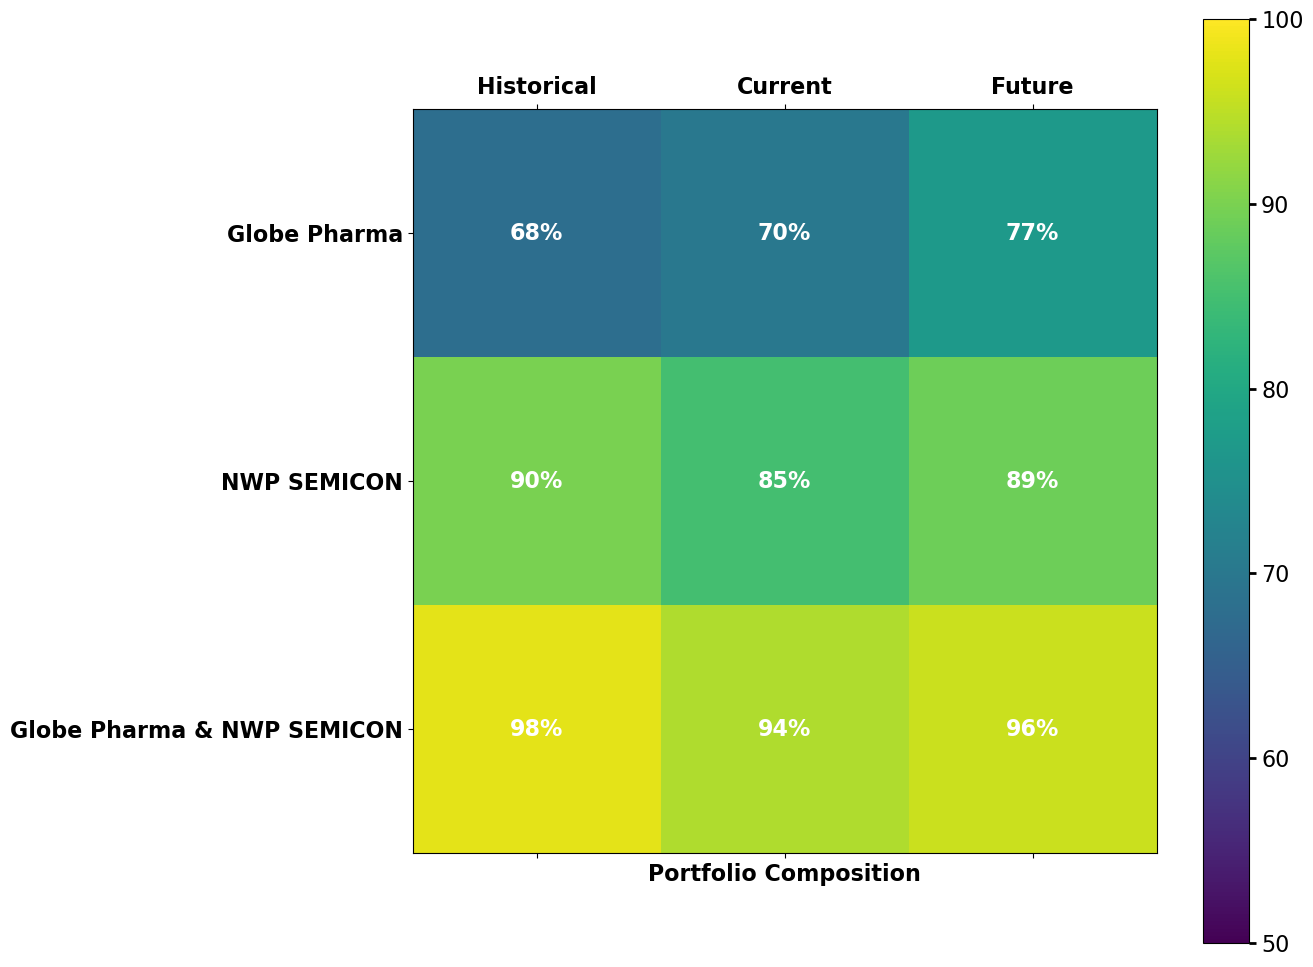

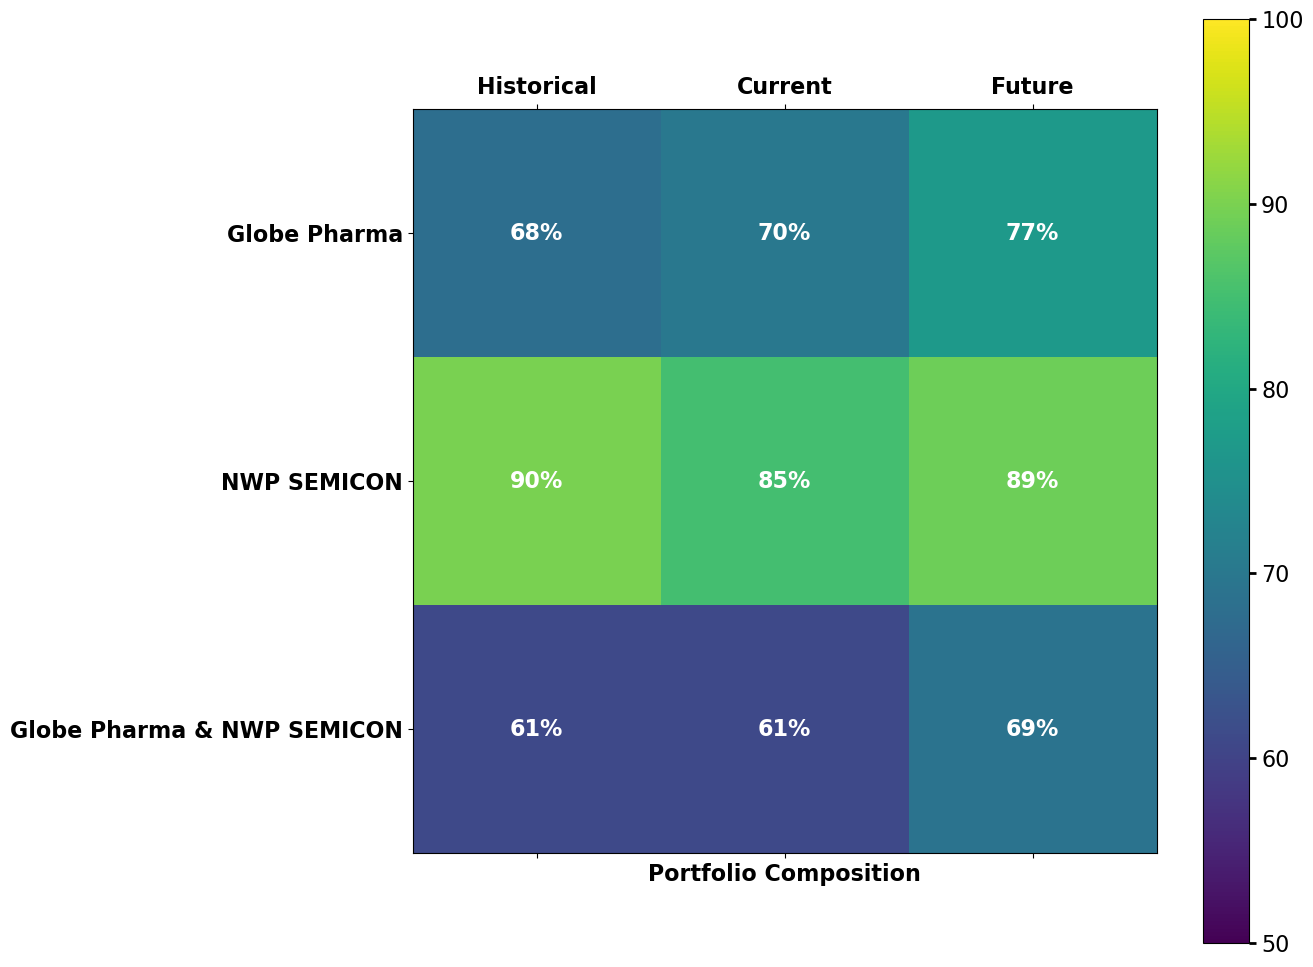

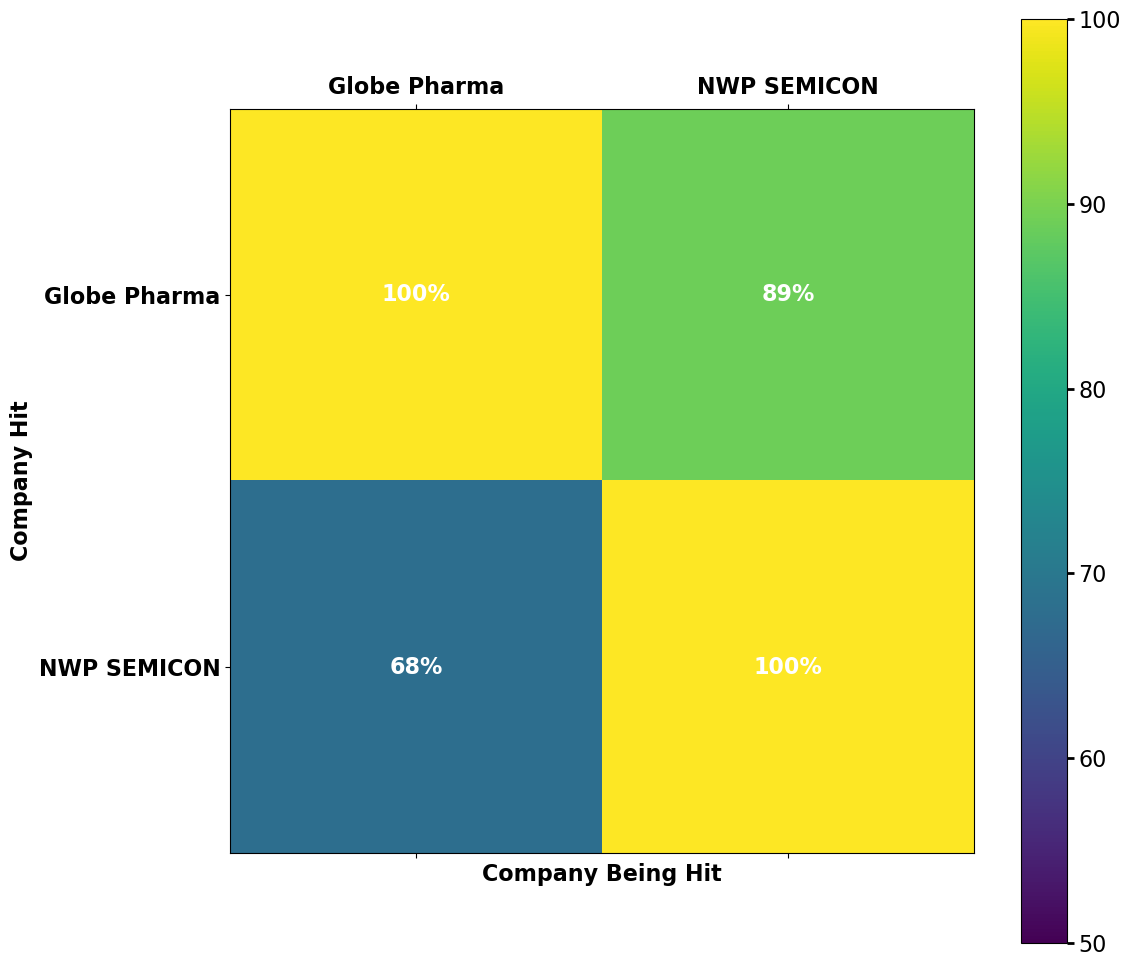

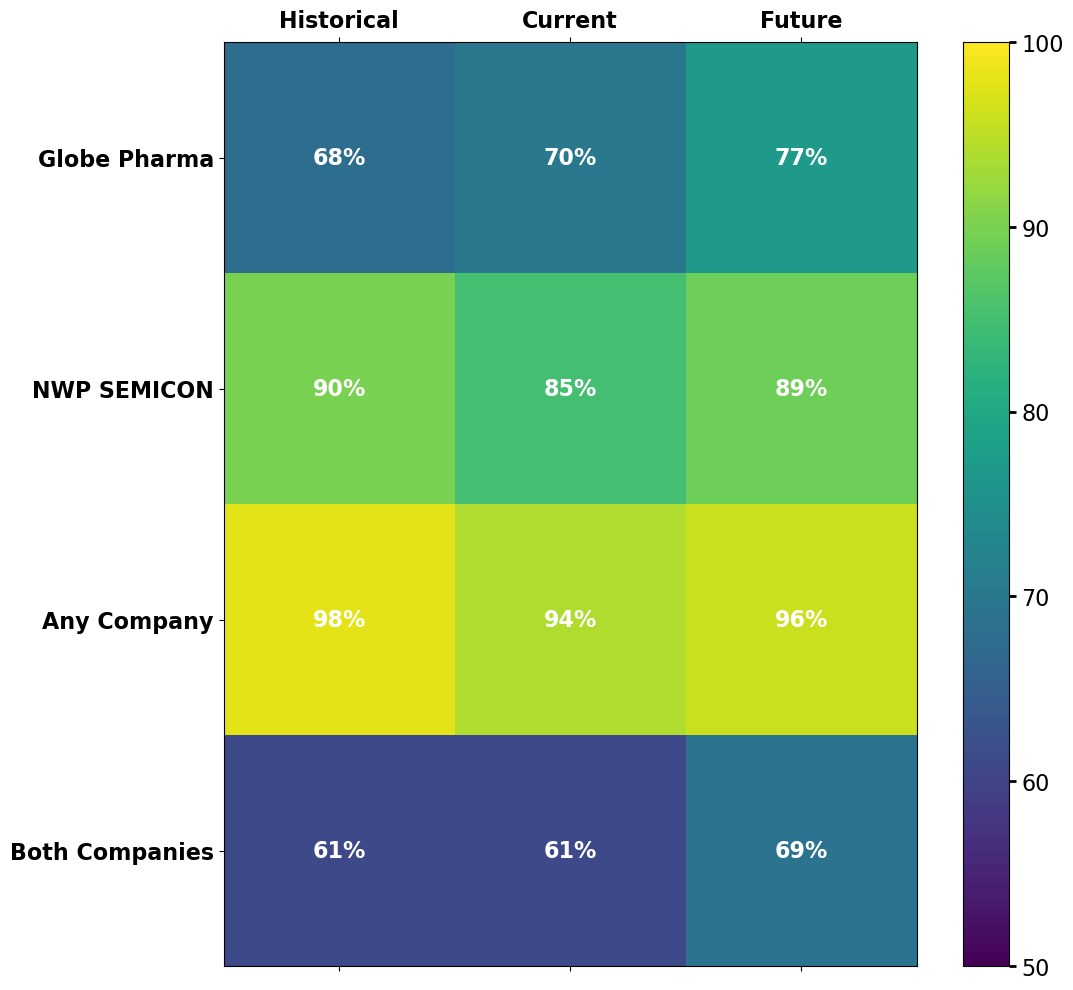

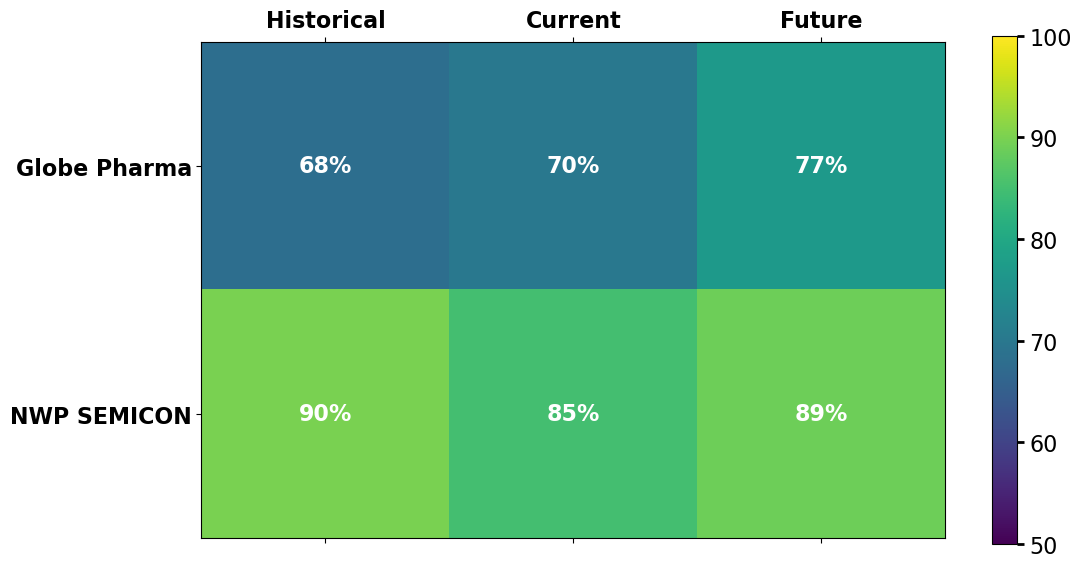

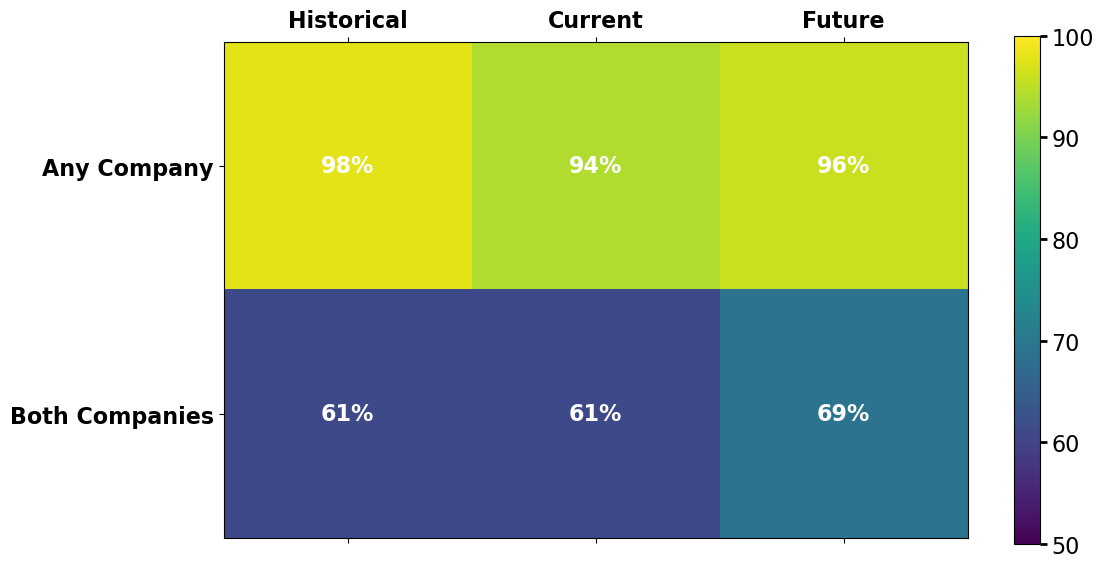

In [63]:


# Set the min and max values for the color bar
vmin = 50
vmax = 100

# Set the colorbar parameters
colorbar_params = {'aspect': 20, 'shrink': 1}

# Set the font size for the plot
font_size = 16
tilt_degrees = 0

# Create the first figure
fig1, ax1 = plt.subplots(figsize=(12, 12))
cax1 = ax1.matshow(rounded_prct_portfolio_hit_df, cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig1.colorbar(cax1, ax=ax1, **colorbar_params)  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax1.set_xticks(range(len(rounded_prct_portfolio_hit_df.columns)))
ax1.set_xticklabels(rounded_prct_portfolio_hit_df.columns, fontsize=font_size, fontweight='bold')
ax1.set_yticks(range(len(rounded_prct_portfolio_hit_df.index)))
ax1.set_yticklabels(rounded_prct_portfolio_hit_df.index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)
# Add the values to the plot as percentages
for i in range(len(rounded_prct_portfolio_hit_df.index)):
    for j in range(len(rounded_prct_portfolio_hit_df.columns)):
        ax1.text(j, i, f"{rounded_prct_portfolio_hit_df.iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')
# Set x-label and y-label descriptions
ax1.set_xlabel('Portfolio Composition', fontsize=font_size, fontweight='bold')
# Print the title
print("The percentage of years when portfolio was hit")

# Create the second figure
fig2, ax2 = plt.subplots(figsize=(12, 12))
cax2 = ax2.matshow(rounded_prct_years_mutual_df, cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig2.colorbar(cax2, ax=ax2, **colorbar_params)  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax2.set_xticks(range(len(rounded_prct_years_mutual_df.columns)))
ax2.set_xticklabels(rounded_prct_years_mutual_df.columns, fontsize=font_size, fontweight='bold')
ax2.set_yticks(range(len(rounded_prct_years_mutual_df.index)))
ax2.set_yticklabels(rounded_prct_years_mutual_df.index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)
# Add the values to the plot as percentages
for i in range(len(rounded_prct_years_mutual_df.index)):
    for j in range(len(rounded_prct_years_mutual_df.columns)):
        ax2.text(j, i, f"{rounded_prct_years_mutual_df.iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')
# Set x-label and y-label descriptions
ax2.set_xlabel('Portfolio Composition', fontsize=font_size, fontweight='bold')
# Print the title
print("The percentage of years when all companies in the portfolio were hit")

# Create the third figure
fig3, ax3 = plt.subplots(figsize=(12, 12))
cax3 = ax3.matshow(rounded_conditional_prob_df[time_periods[0]], cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig3.colorbar(cax3, ax=ax3, **colorbar_params)  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax3.set_xticks(range(len(rounded_conditional_prob_df[time_periods[0]].columns)))
ax3.set_xticklabels(rounded_conditional_prob_df[time_periods[0]].columns, fontsize=font_size, fontweight='bold')
ax3.set_yticks(range(len(rounded_conditional_prob_df[time_periods[0]].index)))
ax3.set_yticklabels(rounded_conditional_prob_df[time_periods[0]].index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)
# Add the values to the plot as percentages
for i in range(len(rounded_conditional_prob_df[time_periods[0]].index)):
    for j in range(len(rounded_conditional_prob_df[time_periods[0]].columns)):
        ax3.text(j, i, f"{rounded_conditional_prob_df[time_periods[0]].iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')
# Set x-label and y-label descriptions
ax3.set_xlabel('Company Being Hit', fontsize=font_size, fontweight='bold')
ax3.set_ylabel('Company Hit', fontsize=font_size, fontweight='bold')
# Print the title
print(f"The conditional probability of a company being hit given that another company was hit for the {haz_set_temp} hazard set")



# Create the fourth figure
fig4, ax4 = plt.subplots(figsize=(12, 12))
cax4 = ax4.matshow(article_plot_df, cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig4.colorbar(cax4, ax=ax4, **colorbar_params)  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax4.set_xticks(range(len(article_plot_df.columns)))
ax4.set_xticklabels(article_plot_df.columns, fontsize=font_size, fontweight='bold')
ax4.set_yticks(range(len(article_plot_df.index)))
ax4.set_yticklabels(article_plot_df.index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)
# Add the values to the plot as percentages
for i in range(len(article_plot_df.index)):
    for j in range(len(article_plot_df.columns)):
        ax4.text(j, i, f"{article_plot_df.iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')
# Set x-label and y-label descriptions
# Print the title
print("The combined data frame for the article plot")

# Filter out the companies article_plot_df
only_companies_plot_df = article_plot_df[article_plot_df.index.isin(['Globe Pharma', 'NWP SEMICON'])]
# # Create the fifth figure
fig5, ax5 = plt.subplots(figsize=(12, 12))
cax5 = ax5.matshow(only_companies_plot_df, cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig5.colorbar(cax5, ax=ax5, **{'aspect': 20, 'shrink': 0.55})  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax5.set_xticks(range(len(only_companies_plot_df.columns)))
ax5.set_xticklabels(only_companies_plot_df.columns, fontsize=font_size, fontweight='bold')
ax5.set_yticks(range(len(only_companies_plot_df.index)))
ax5.set_yticklabels(only_companies_plot_df.index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)
# Add the values to the plot as percentages
for i in range(len(only_companies_plot_df.index)):
    for j in range(len(only_companies_plot_df.columns)):
        ax5.text(j, i, f"{only_companies_plot_df.iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')
# Set x-label and y-label descriptions
# Print the title
        
# Filter out non-companies
non_companies_plot_df = article_plot_df[~article_plot_df.index.isin(['Globe Pharma', 'NWP SEMICON'])]
# Create the sixth figure
fig6, ax6 = plt.subplots(figsize=(12, 12))
cax6 = ax6.matshow(non_companies_plot_df, cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig6.colorbar(cax6, ax=ax6, **{'aspect': 20, 'shrink': 0.55})  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax6.set_xticks(range(len(non_companies_plot_df.columns)))
ax6.set_xticklabels(non_companies_plot_df.columns, fontsize=font_size, fontweight='bold')
ax6.set_yticks(range(len(non_companies_plot_df.index)))
ax6.set_yticklabels(non_companies_plot_df.index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)
# Add the values to the plot as percentages
for i in range(len(non_companies_plot_df.index)):
    for j in range(len(non_companies_plot_df.columns)):
        ax6.text(j, i, f"{non_companies_plot_df.iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')


# Display the plot
plt.show()




# Risk metrics – VaR and Expected Shortfall

### Simulate replacements costs ( for the risk metrics we do not use the historical year set)

In [64]:
# Generate the sampled impacts for the historical hazard set
imp_per_year_dict, sampling_vect_dict = generate_sampled_imp_per_year(imp_dict, n_sampled_years=n_years) # Here we do not use the historical yearsets

## Risk metrics

### Make a function to calc expected shortfall

In [65]:
# Calc portfolio risk metrics

# Make a function that calculates the return period and aai for a given impact list and portfolio weights
def calc_rp_aai(cpny_weights, imp_list, denominators, return_period = 100):
    imp_port = copy.deepcopy(imp_list[0]) # gives the relative change in impact
    imp_port.at_event = np.zeros(len(imp_port.at_event))
    imp_port.aai_agg = 0.0000000
    for idx, imp in enumerate(imp_list):
        imp_port.at_event += imp.at_event*cpny_weights[idx] / denominators[idx]
        imp_port.aai_agg = imp_port.aai_agg*cpny_weights[idx] / denominators[idx]

    port_freq_curve = imp_port.calc_freq_curve(return_per=np.array([return_period]))
    port_aai_agg = imp_port.aai_agg  # Return period in prct of the total asset value
    
    return -1*port_freq_curve.impact[0], port_aai_agg

# Make a function that calculates the portfolio risk metrics ES, VaR and risk attribution Marginal ES
def calc_portfolio_risk_metrics(cpny_weights, sim_costs, imp_list, denominators, alpha, return_period=100, var_method='RP'):
    # Calculate the portfolio losses
    sim_cpny_losses = -1*cpny_weights*sim_costs/denominators
    sim_port_losses = np.sum(sim_cpny_losses, axis=1)
    # Calculate the value at risk
    if var_method == 'RP':
        var = calc_rp_aai(cpny_weights, imp_list, denominators, return_period = return_period)[0]
    elif var_method == 'Quantile':
        var = np.quantile(sim_port_losses, alpha)
    else:
        raise ValueError("var must be either 'RP' or 'Quantile'")
    # Calculate the expected shortfall
    es = np.mean(sim_port_losses[sim_port_losses <= var])
    # Calculate the risk attribution
    risk_attribution = np.mean(sim_cpny_losses[sim_port_losses <= var], axis=0)
    return var, es, risk_attribution

# Calculate the portfolio risk metrics for the historical hazard set
# Define the portfolio weights all companies have the same weight 
cpny_weights = np.ones(len(companies))/len(companies)
# Define th impact list
imp_list = [imp_dict['Historical']['Gross'][cpny] for cpny in companies]
# Define the simulated costs
sim_costs = imp_per_year_dict['Historical']['Gross'][companies].values
# Define the denominators
denominators = np.ones(len(companies))
# Define the alpha value
alpha = 1/return_period
# Calculate the value at risk and expected shortfall using RP
var, es, risk_attribution = calc_portfolio_risk_metrics(cpny_weights, sim_costs, imp_list, denominators, alpha, var_method='RP')
print(f'The value at risk is {var} and the expected shortfall is {es}')

# Calculate the value at risk and expected shortfall using the quantile
var, es, risk_attribution = calc_portfolio_risk_metrics(cpny_weights, sim_costs, imp_list, denominators, alpha, var_method='Quantile')
print(f'The value at risk is {var} and the expected shortfall is {es}')



The value at risk is -0.1014785988417454 and the expected shortfall is -0.11412805820984681
The value at risk is -0.11285505251241224 and the expected shortfall is -0.13468934029814658


### Make a function to optimize the expected shortfall

In [66]:
# Make a function that finds to optimal portfolio weights that minimizes the expected shortfall or value at risk for a given impact list

def find_optimal_portfolio_weights(sim_costs, imp_list, denominators, alpha, return_period, var_method):

    # Get the number of companies
    n_cpny = np.shape(sim_costs)[1]

    # Define the objective function
    def objective(cpny_weights, sim_costs, denominators, alpha):
        return -1*calc_portfolio_risk_metrics(cpny_weights, sim_costs, imp_list, denominators, alpha, return_period, var_method)[1]

    # Define the constraints
    def constraint1(cpny_weights):
        return np.sum(cpny_weights) - 1

    def constraint2(cpny_weights):
        return cpny_weights

    # Define the initial guess
    initial_guess = np.ones(n_cpny) / n_cpny

    # Define the bounds
    bounds = [(0, 1) for i in range(n_cpny)]

    # Define the constraints
    constraints = [{'type': 'eq', 'fun': constraint1},
                   {'type': 'ineq', 'fun': constraint2}]

    # Find the optimal portfolio weights
    opt_res = minimize(objective, initial_guess, args=(sim_costs, denominators, alpha), method='SLSQP', bounds=bounds, constraints=constraints)

    # Return the optimal portfolio weights
    return opt_res.x


### Try the optimizer function

In [67]:
# Try the function

time = 'Future'
imp_type = 'Gross'

# Define the simulated costs
sim_costs = imp_per_year_dict[time][imp_type][companies].values
# Define the denominators
denominators = np.ones(len(companies))
# Define th impact list
imp_list = [imp_dict[time][imp_type][cpny] for cpny in companies]
# Define the alpha value
alpha = 1/return_period

# Weights given 
cpny_weights = None # None #np.ones(len(companies))/len(companies) np.array([1,0])

# Find the optimal portfolio weights
if cpny_weights is None:
    # Find the optimal portfolio weights for the value at risk
    cpny_weights_RP = find_optimal_portfolio_weights(sim_costs, imp_list, denominators, alpha, return_period, var_method='RP')
    print(f'The optimal portfolio weights for RP is {cpny_weights_RP}')
    # Find the optimal portfolio weights for the expected shortfall
    cpny_weights_QT = find_optimal_portfolio_weights(sim_costs, imp_list, denominators, alpha, return_period, var_method='Quantile')
    print(f'The optimal portfolio weights for Quantile is {cpny_weights_QT}', '\n')
else:
    print('\n', 'The portfolio weights are already given', '\n')
    cpny_weights_RP = cpny_weights
    cpny_weights_QT = cpny_weights



# Calculate the value at risk and expected shortfall using the optimal portfolio weights
# Print the optimal portfolio weights and the value at risk and 
var, es, risk_attribution = calc_portfolio_risk_metrics(cpny_weights_RP, sim_costs, imp_list, denominators, alpha, return_period, var_method='RP')
print(f'For RP method and optimal RP weights : The value at risk is {var} and the expected shortfall is {es}')
var, es, risk_attribution = calc_portfolio_risk_metrics(cpny_weights_QT, sim_costs, imp_list, denominators, alpha, var_method='RP')
print(f'For RP method and optimal QT weights : The value at risk is {var} and the expected shortfall is {es}', '\n')

# Calculate the value at risk and expected shortfall using the optimal portfolio weights
# Print the optimal portfolio weights and the value at risk and
var, es, risk_attribution = calc_portfolio_risk_metrics(cpny_weights_RP, sim_costs, imp_list, denominators, alpha, return_period, var_method='Quantile')
print(f'For Quantile method and optimal RP weights : The value at risk is {var} and the expected shortfall is {es}')
var, es, risk_attribution = calc_portfolio_risk_metrics(cpny_weights_QT, sim_costs, imp_list, denominators, alpha, return_period, var_method='Quantile')
print(f'For Quantile method and optimal QT weights : The value at risk is {var} and the expected shortfall is {es}', '\n')



The optimal portfolio weights for RP is [0.68807716 0.31192284]
The optimal portfolio weights for Quantile is [0.68702848 0.31297152] 

For RP method and optimal RP weights : The value at risk is -0.13221084650649678 and the expected shortfall is -0.17544310260488877
For RP method and optimal QT weights : The value at risk is -0.13200934848059412 and the expected shortfall is -0.1755083156335373 

For Quantile method and optimal RP weights : The value at risk is -0.16867035593713786 and the expected shortfall is -0.21053953206073955
For Quantile method and optimal QT weights : The value at risk is -0.16901724668242774 and the expected shortfall is -0.2105348361205091 



### Calc the perfomance for each strategy

#### Parameters

In [68]:
# Calculate the value at risk and expected shortfall using the optimal portfolio weights using either RP or Quantile method

var_method = 'Quantile' # 'Quantile' or 'RP' 

#### Calc the perfromance

In [69]:
# denominators
tot_cpny_values = [asset_tot_value_dict[cpny] for cpny in companies]

# Store all results in a data frame
base_columns = ['Time period', 'Impact type', 'Portfolio Strategy'] 
risk_metrics_df = pd.DataFrame(columns=base_columns + [ 'ES', 'VaR'])
risk_attr_df = pd.DataFrame(columns=base_columns  + ['Company', 'Marginal ES'])
weights_df = pd.DataFrame(columns=base_columns +  ['Company', 'Weight'])


# Define the denominators (used to calculate the relative risk attribution)
denominators = np.ones(len(companies))

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Get the impact objects for the portfolio strategy
        sim_imp_per_year = imp_per_year_dict[time][imp_type]
        imp_list =  [imp_dict[time][imp_type][cpny] for cpny in companies]


        # Calculate the total indirect exposure from each campny for each portfolio strategy
        for port_strat in portfolio_strategies:
            # If optimal calc the optimal portfolio
            if port_strat == 'Optimal':
                # Get the optimal portfolio strategy
                weights = find_optimal_portfolio_weights(sim_imp_per_year[companies].values, imp_list,  denominators, alpha, return_period, var_method=var_method)
            else:
                # Get the portfolio strategy
                weights = portfolio_weights_base_df.loc[port_strat, companies].values

             # Total indirect exposure
            tot_indirect_exp = np.sum(weights*tot_cpny_values)

            # Calculate the portfolio ES (absolute and relative)
            var, es, risk_attr = calc_portfolio_risk_metrics(weights, sim_imp_per_year[companies].values, imp_list, denominators, alpha, return_period, var_method=var_method)
            # Change the sign of the var if it is negative
            if var < 0:
                var = -1 * var
            # Change the sign of the es if it is negative
            if es < 0:
                es = -1 * es # Change the sign of the es
            # Change the sign of the risk attribution if it is negative
            risk_attr = [-1*attr if attr < 0 else attr for attr in risk_attr]


            # update the data frames
            risk_metrics_df.loc[len(risk_metrics_df)] =  [time, imp_type, port_strat, es, var]
            # store the risk attribution and weights
            for idx, cpny in enumerate(companies):
                risk_attr_df.loc[len(risk_attr_df)] = [time, imp_type, port_strat, cpny] +  [risk_attr[idx]]

                #risk_attr_df.loc[len(risk_attr_df)] = [time, imp_type, 'Relative', port_strat, cpny] + [-1*risk_attr_abs[idx]/tot_indirect_exp*100]
                weights_df.loc[len(weights_df)] = [time, imp_type, port_strat, cpny] + [weights[idx]]

### Print the results

In [70]:
# Print the results for the absolute and relative  ES gross and net for the different portfolio strategies for each time period
for imp_type in imp_types:
    for time in haz_dict.keys():
        print(f'The risk metrics for the {time} {imp_type} hazard set', '\n')
        print(tabulate.tabulate(risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Impact type'] == imp_type)], headers='keys', tablefmt='pipe'))
        print("\n")

    

The risk metrics for the Historical Gross hazard set 

|    | Time period   | Impact type   | Portfolio Strategy   |       ES |      VaR |
|---:|:--------------|:--------------|:---------------------|---------:|---------:|
|  0 | Historical    | Gross         | Globe Pharma         | 0.207819 | 0.203466 |
|  1 | Historical    | Gross         | NWP SEMICON          | 0.22422  | 0.19461  |
|  2 | Historical    | Gross         | Equal                | 0.134689 | 0.112855 |
|  3 | Historical    | Gross         | Optimal              | 0.134642 | 0.113106 |


The risk metrics for the Current Gross hazard set 

|    | Time period   | Impact type   | Portfolio Strategy   |       ES |      VaR |
|---:|:--------------|:--------------|:---------------------|---------:|---------:|
|  8 | Current       | Gross         | Globe Pharma         | 0.207236 | 0.145528 |
|  9 | Current       | Gross         | NWP SEMICON          | 0.3121   | 0.24088  |
| 10 | Current       | Gross         | Equal       

### Calculate the risk transfer

In [71]:
# For each strategy, calculate the risk transfer

risk_attr_incl_risk_transf_df = risk_attr_df.copy()

for time in haz_dict.keys():
        for port_strat in portfolio_strategies:
            for cpny in companies:
                # Get the gross risk attribution for the current company and portfolio strategy
                gross_risk_attr = risk_attr_df[(risk_attr_df['Time period'] == time) & (risk_attr_df['Portfolio Strategy'] == port_strat) & (risk_attr_df['Company'] == cpny) & (risk_attr_df['Impact type'] == 'Gross')]['Marginal ES'].values[0]
                # Get the net risk attribution for the current company and portfolio strategy
                net_risk_attr = risk_attr_df[(risk_attr_df['Time period'] == time) & (risk_attr_df['Portfolio Strategy'] == port_strat) & (risk_attr_df['Company'] == cpny) & (risk_attr_df['Impact type'] == 'Net')]['Marginal ES'].values[0]
                # Calculate the risk transfer
                risk_transf = gross_risk_attr - net_risk_attr
                # Update the data frame with an additonal row withe the risk transfer for the current company and portfolio strategy and time period and impact type 'risk transfer'
                risk_attr_incl_risk_transf_df.loc[len(risk_attr_incl_risk_transf_df)] = [time, 'Risk Transfer', port_strat, cpny, risk_transf]

# Create column Legend bar as company plus impact type 
risk_attr_incl_risk_transf_df['Risk Attribution'] = risk_attr_incl_risk_transf_df['Company'] + ' (' + risk_attr_incl_risk_transf_df['Impact type'] + ')'


### Utility function for plotting

In [72]:
# Filter the data based on a dictionary of filters

def filter_dataframe(df, filters, columns_to_remove):
    df_copy = df.copy()  # make a copy of the DataFrame
    for col, values in filters.items():
        df_copy = df_copy[df_copy[col].isin(values)]
    df_copy = df_copy.drop(columns=columns_to_remove)
    return df_copy



### Define the colors

In [73]:
import seaborn as sns
import re
import matplotlib.colors as mcolors


# Get the unique companies in the data frame
unique_companies = risk_attr_incl_risk_transf_df['Company'].unique()

# Generate distinct colors for each company
company_colors = dict(zip(unique_companies, sns.color_palette("hls", len(unique_companies))))

# Create the color mapping dictionary
color_mapping = {}

# Assign distinct color to (netto) and light version of the color to (gross) for each company
for company in unique_companies:
    if company in company_colors:
        color_mapping[company] = company_colors[company]
        color_mapping[company + ' (Net)'] = company_colors[company]
        color_mapping[company + ' (Risk Transfer)'] = sns.light_palette(company_colors[company])[2]  # Use a lighter shade for gross

color_mapping

# Convert RGB colors to hexadecimal format
color_mapping_hex = {k: mcolors.rgb2hex(v) for k, v in color_mapping.items()}



### Plot - Risk per company

In [74]:
# Define the filters
filters = { 'Portfolio Strategy': portfolio_strategies[0:2], 'Impact type': ['Net', 'Risk Transfer']}
# Define the columns to remove
columns_to_remove = []


# Filter the data frame
filt_risk_attr_df = filter_dataframe(risk_attr_incl_risk_transf_df, filters, columns_to_remove)
df = filt_risk_attr_df

group_col = 'Time period'
sub_group_col = 'Portfolio Strategy'
legend_col = 'Risk Attribution'
stack_col = 'Marginal ES'


xaxis_title = ''
yaxis_title = 'Replacement Costs (US$ billion)'

# Create a new figure
fig = go.Figure()

# Font color dark blue
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 28
adjustment = 0.05

font_dict = dict(size=font_size, family=font_family, color=font_color)

fig.update_layout(
    template="plotly_white",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    barmode="stack",
    bargap=0.2,
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    height=1000,
    width=1800,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    # Reverse the legend order
    legend_traceorder="reversed",
)



# Begin with the Net Risk
# Get the legend values in alphabetical order
legend_values = df[legend_col].unique()
# Reverse the order of the legend values
legend_values = legend_values[::-1]
# Only include net 
legend_values_Net = [leg for leg in legend_values if 'Net' in leg]



# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_Net]


# For each unique value in the legend column and its corresponding color
for legend_value, color in zip(legend_values_Net, colors):
    print(legend_value)
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    # Add a bar to the figure for the current legend value
    fig.add_trace(
        go.Bar(
            x=[plot_df[group_col], plot_df[sub_group_col]], 
            y=plot_df[stack_col], 
            name=legend_value, 
            marker_color=color, 
            textfont=dict(size=font_size, family=font_family, color=font_color),
        ),
    )

    
# Plot the VaR Gross
for i, time in enumerate(df['Time period'].unique()):
    for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
        # Get the Gross VaR from risk metrics df
        
        net_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['VaR'].values[0]

        # Convert time and company to pandas Series with a single value
        time_series = pd.Series([time])
        company_series = pd.Series([port_strat])

        # Add of the VaR Gross
        fig.add_trace(
            go.Scatter(
                x= [time_series, company_series],
                y= [net_var], 
                marker_color= 'black',
                marker_symbol= 'x',
                name= '1% Value-At-Risk (Net)', 
                mode='markers',
                showlegend= i == 0 and j ==0,
                marker_size= 20
            ),
        )



# Begin with the Gross Risk
# Get the legend values in alphabetical order
legend_values_RT = [leg for leg in legend_values if 'Risk Transfer' in leg]


# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_RT]


# For each unique value in the legend column and its corresponding color
for legend_value, color in zip(legend_values_RT, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    # Add a bar to the figure for the current legend value
    fig.add_trace(
        go.Bar(
            x=[plot_df[group_col], plot_df[sub_group_col]], 
            y=plot_df[stack_col], 
            name=legend_value, 
            marker_color=color, 
            textfont=dict(size=font_size, family=font_family, color=font_color),
        ),
    )


    
# Plot the VaR Gross
for i, time in enumerate(df['Time period'].unique()):
    for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
        # Get the Gross VaR from risk metrics df
        gross_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Gross')]['VaR'].values[0]
        gross_es = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Gross')]['ES'].values[0]

        # Convert time and company to pandas Series with a single value
        time_series = pd.Series([time])
        company_series = pd.Series([port_strat])

        # Add of the VaR Gross
        fig.add_trace(
            go.Scatter(
                x= [time_series, company_series],
                y= [gross_var], 
                marker_color= 'black',
                name= '1% Value-At-Risk (Gross)', 
                mode='markers',
                showlegend= i == 0 and j ==0,
                marker_size= 20
            ),
        )

        # Add of the ES Gross as text on the top of the bar
        fig.add_trace(
            go.Scatter(
                x= [time_series, company_series],
                y= [gross_es*1.01],
                name= 'ES Gross', 
                mode='text',
                text= [gross_es.round(2)],
                textposition='top center',
                     textfont=dict(
                    color='black', 
                    size=font_size, 
                    family= font_family
                ),
                showlegend=False
            ),
        )




fig.show()

NWP SEMICON (Net)
Globe Pharma (Net)


### Plot - Risk attribution per company and strategy

In [75]:
# Define the filters
filters = { 'Portfolio Strategy': portfolio_strategies[:], 'Impact type': ['Net', 'Risk Transfer']}
# Define the columns to remove
columns_to_remove = []


# Filter the data frame
filt_risk_attr_df = filter_dataframe(risk_attr_incl_risk_transf_df, filters, columns_to_remove)
df = filt_risk_attr_df

group_col = 'Time period'
sub_group_col = 'Portfolio Strategy'
legend_col = 'Risk Attribution'
stack_col = 'Marginal ES'


xaxis_title = ''
yaxis_title = 'Replacement Costs (US$ billion)'

# Create a new figure
fig = go.Figure()

# Font color dark blue
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 28
adjustment = 0.05

font_dict = dict(size=font_size, family=font_family, color=font_color)

fig.update_layout(
    template="plotly_white",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    barmode="stack",
    bargap=0.2,
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    height=1000,
    width=1800,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    # Reverse the legend order
    legend_traceorder="reversed",
)



# Begin with the Net Risk
# Get the legend values in alphabetical order
legend_values = df[legend_col].unique()
# Reverse the order of the legend values
legend_values = legend_values[::-1]
# Only include net 
legend_values_Net = [leg for leg in legend_values if 'Net' in leg]


# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_Net]


# For each unique value in the legend column and its corresponding color
for legend_value, color in zip(legend_values_Net, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    # Add a bar to the figure for the current legend value
    fig.add_trace(
        go.Bar(
            x=[plot_df[group_col], plot_df[sub_group_col]], 
            y=plot_df[stack_col], 
            name=legend_value, 
            marker_color=color, 
            textfont=dict(size=font_size, family=font_family, color=font_color),
        ),
    )


    
# Plot the VaR Gross
for i, time in enumerate(df['Time period'].unique()):
    for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
        # Get the Net VaR from risk metrics df
        net_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['VaR'].values[0]
        net_es = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['ES'].values[0]

        # Convert time and company to pandas Series with a single value
        time_series = pd.Series([time])
        company_series = pd.Series([port_strat])

        # Add of the VaR Gross
        fig.add_trace(
            go.Scatter(
                x= [time_series, company_series],
                y= [net_var], 
                marker_color= 'black',
                marker_symbol= 'x',
                name= '1% Value-At-Risk (Net)', 
                mode='markers',
                showlegend= i == 0 and j ==0,
                marker_size= 20
            ),
        )

        # Add of the ES Net as text on the top of the bar
        fig.add_trace(
            go.Scatter(
                x= [time_series, company_series],
                y= [net_es*1.02],
                name= 'ES Net', 
                mode='text',
                text= [net_es.round(2)],
                textposition='top center',
                     textfont=dict(
                    color='black', 
                    size=font_size, 
                    family= font_family
                ),
                showlegend=False
            ),
        )



fig.show()

### Plot - Portfolio Weights

In [76]:
weights_df

import seaborn as sns
import re


# Define the filters
filters = {'Portfolio Strategy': ['Optimal']}
# Define the columns to remove
columns_to_remove = []

xaxis_title = ''
yaxis_title = 'Optimal Portfolio Weights'

# Filter the data frame
filt_weights_df = filter_dataframe(weights_df, filters, columns_to_remove)
df = filt_weights_df
#colors = px.colors.qualitative.Plotly[:len(df[legend_col].unique())]

# Create a new figure
fig = go.Figure()

# Font color dark blue
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 30
adjustment = 0.05

font_dict = dict(size=font_size, family=font_family, color=font_color)

fig.update_layout(
    template="plotly_white",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    barmode="stack",
    bargap=0.2,
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    height=1000,
    width=1800,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
)

group_col = 'Time period'
sub_group_col = 'Impact type'
legend_col = 'Company'
stack_col = 'Weight'

# Update the IMpact type values to Gross Risk and Net Risk
df['Impact type'] = df['Impact type'].replace({'Gross': 'Gross Risk', 'Net': 'Net Risk'})


# Get the legend values in alphabetical order
legend_values = df[legend_col].unique()
# Get the unique values in the legend column, in reverse order

# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values]


# For each unique value in the legend column and its corresponding color
for legend_value, color in zip(legend_values, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    # Add a bar to the figure for the current legend value
    fig.add_trace(
        go.Bar(
            x=[plot_df[group_col], plot_df[sub_group_col]], 
            y=plot_df[stack_col], 
            name=legend_value, 
            marker_color=color, 
            textfont=dict(size=18, family="Courier New", color="RebeccaPurple")
        ),
    )

    # Add the text on top of the bar for the first iteration
    if legend_value == legend_values[0]:
        # Add of the ES Net as text on the top of the bar
        fig.add_trace(
            go.Scatter(
                x= [plot_df[group_col], plot_df[sub_group_col]],
                y= plot_df[stack_col], 
                name= 'Portfolio weights',
                mode='text',
                text= [f"{weight:.2f}" for weight in plot_df[stack_col]],
                textposition='top center',
                     textfont=dict(
                    color='black', 
                     size=font_size, 
                    family= font_family
                ),
                showlegend=False
            ),
        )




fig.show()